# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

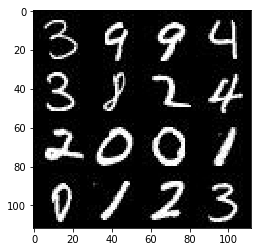

In [2]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

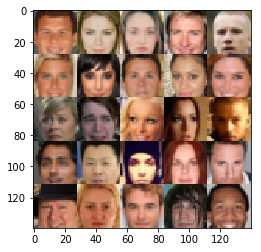

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
#image = mnist_images[1]
#maximum = np.max(image)
#minimum = np.min(image)
#image = np.subtract(image,minimum)
#image = np.multiply(image,2/maximum)
#image = np.subtract(image,1)
#print(image)

pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    kernel_size = 5
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, kernel_size, strides=2, padding='same',
                                       kernel_initializer=tf.keras.initializers.glorot_normal())
        x1 = tf.layers.dropout(x1, 0.2)
        relu1 = tf.maximum(alpha*x1, x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, kernel_size, strides=2, padding='same',
                                       kernel_initializer=tf.keras.initializers.glorot_normal())
        x2 = tf.layers.dropout(x1, 0.2)        
        relu2 = tf.maximum(alpha*x2, x2)
        #7x7x128
        
        x3 = tf.layers.conv2d(relu1, 256, kernel_size, strides=2, padding='same',
                                       kernel_initializer=tf.keras.initializers.glorot_normal())
        x3 = tf.layers.dropout(x3, 0.2)       
        relu3 = tf.maximum(alpha*x3, x3)
        #4x4x256
        
        #x4 = tf.layers.conv2d(relu1, 256, kernel_size, strides=1, padding='same',
        #                               kernel_initializer=tf.keras.initializers.glorot_normal())
        #x4 = tf.layers.dropout(x1, 0.05)        
        #relu4 = tf.maximum(alpha*x4, x4)
        #4x4x512
        
        #Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)   
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    kernel_size = 5
    with tf.variable_scope('generator', reuse=(not is_train)):
        #First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.layers.dropout(x1, 0.2)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 128, kernel_size, strides=2, padding='same',
                                       kernel_initializer=tf.keras.initializers.glorot_normal())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.layers.dropout(x2, 0.2)
        x2 = tf.maximum(alpha * x2, x2)
        #14x14x256  

        x3 = tf.layers.conv2d_transpose(x2, 64, kernel_size, strides=2, padding='same',
                                       kernel_initializer=tf.keras.initializers.glorot_normal())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.layers.dropout(x3, 0.2)
        x3 = tf.maximum(alpha * x3, x3)
        #28x28x128
        
        x4 = tf.layers.conv2d_transpose(x3, 32, kernel_size, strides=1, padding='same',
                                       kernel_initializer=tf.keras.initializers.glorot_normal())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.layers.dropout(x4, 0.2)
        x4 = tf.maximum(alpha * x4, x4)
        #28x28x64
        
        #Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, kernel_size, strides=1, padding='same')
        #28x28x3 now       

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every=20
    show_every=100
    samples, losses = [], []    
    steps=0
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps+=1
                
                #Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Rescale batch images
                batch_images = batch_images*2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                #_ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 32, input_z, image_channels, data_image_mode)
  
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 1.5341... Generator Loss: 0.5946
Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 0.6643
Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 0.7611


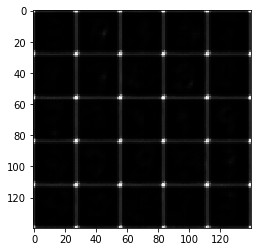

Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.7289
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.7734
Epoch 1/2... Discriminator Loss: 1.4158... Generator Loss: 0.6991


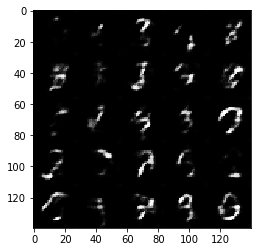

Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.8010
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.7792


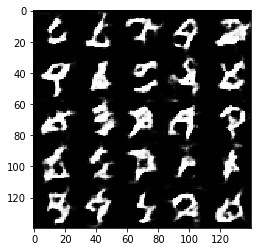

Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 0.7210
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.7643
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 0.7367
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.7804


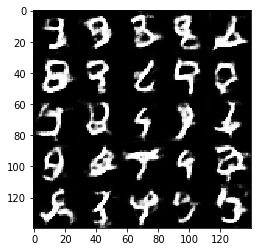

Epoch 1/2... Discriminator Loss: 1.4103... Generator Loss: 0.6622
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 0.7873
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 0.8917


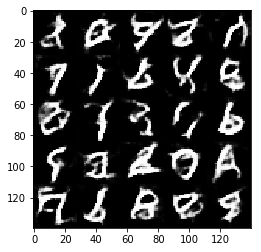

Epoch 1/2... Discriminator Loss: 1.4177... Generator Loss: 0.7214
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.7548
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.7245
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.7673


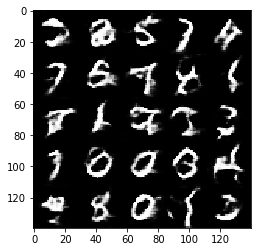

Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.7747
Epoch 1/2... Discriminator Loss: 1.4118... Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.6999
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.7978


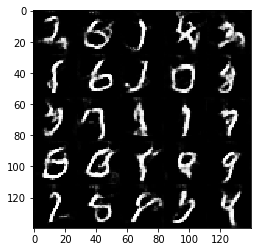

Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.7075
Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.7186


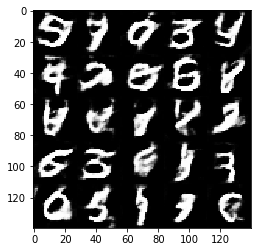

Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.7899
Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 0.7424
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.7437


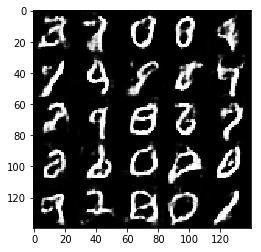

Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.9628
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.9485


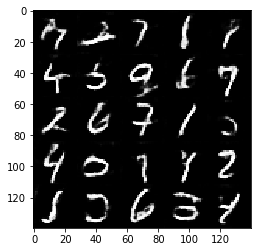

Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 0.7146
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 1.4982... Generator Loss: 0.5121
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.7371


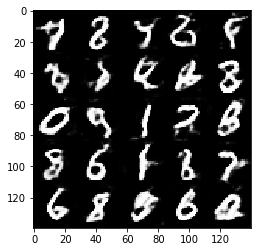

Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 0.7142
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 1.4133... Generator Loss: 0.5701


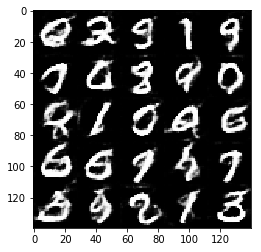

Epoch 1/2... Discriminator Loss: 1.4714... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.7462
Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 0.7541
Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.6981
Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.7784


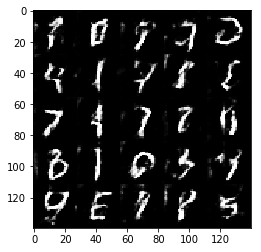

Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.7663
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.7101
Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 0.7877


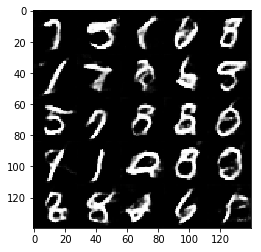

Epoch 1/2... Discriminator Loss: 1.3221... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.7504


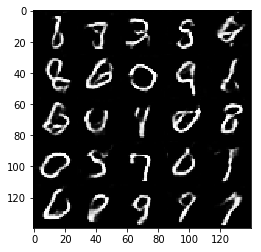

Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.7985
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.7136
Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 0.7233


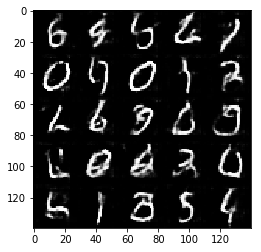

Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.7344
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.6361


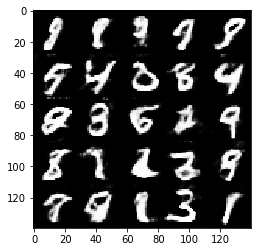

Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 1.3244... Generator Loss: 0.7970
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.8315
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 1.4495... Generator Loss: 0.6060


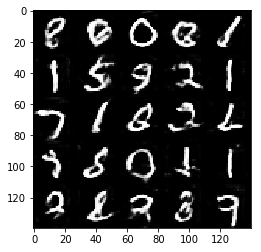

Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.8119
Epoch 1/2... Discriminator Loss: 1.4162... Generator Loss: 0.7353
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 0.5546
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 0.7288


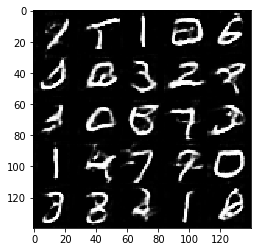

Epoch 2/2... Discriminator Loss: 1.4051... Generator Loss: 0.7553
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.7856
Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.8643
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.7061
Epoch 2/2... Discriminator Loss: 1.4118... Generator Loss: 0.7876


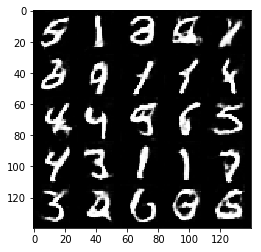

Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 0.7487
Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.7108
Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 0.7641


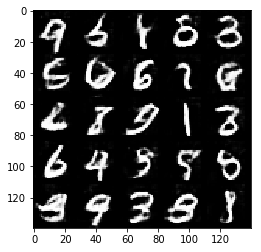

Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.7963
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 1.3522... Generator Loss: 0.7963
Epoch 2/2... Discriminator Loss: 1.3878... Generator Loss: 0.6876
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.7174


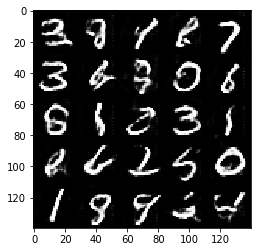

Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.6320
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.6812
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.7963
Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.4524... Generator Loss: 0.6471


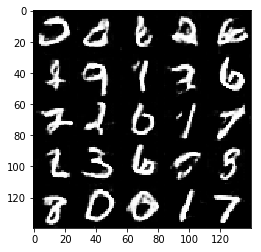

Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 1.4066... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.7717
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.8231


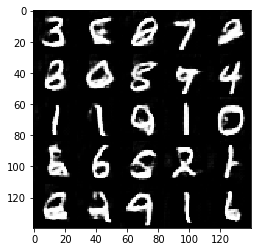

Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.4110... Generator Loss: 0.6525
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.3538... Generator Loss: 0.6981


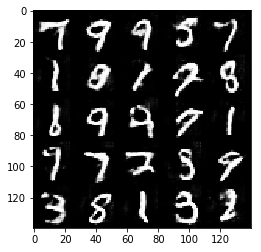

Epoch 2/2... Discriminator Loss: 1.4633... Generator Loss: 0.9288
Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 0.8517
Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 0.7608
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.8072


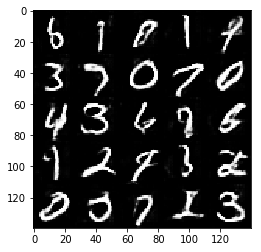

Epoch 2/2... Discriminator Loss: 1.4564... Generator Loss: 0.7056
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 0.7863
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.6858
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6829


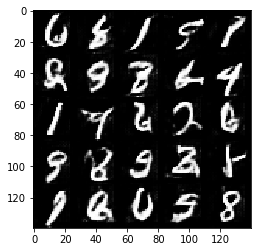

Epoch 2/2... Discriminator Loss: 1.3834... Generator Loss: 0.7583
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.6391
Epoch 2/2... Discriminator Loss: 1.3750... Generator Loss: 0.8176
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 1.4026... Generator Loss: 0.9306


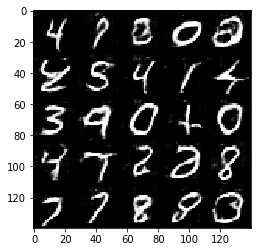

Epoch 2/2... Discriminator Loss: 1.4066... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.8443
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.7434


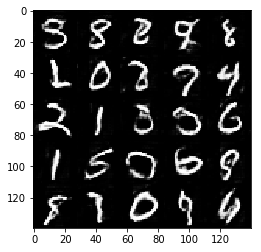

Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 0.7462
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.9464
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.7969


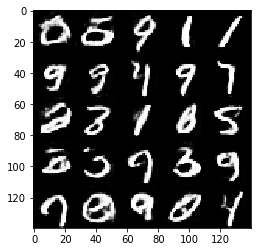

Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.7289
Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 0.7159
Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.7816


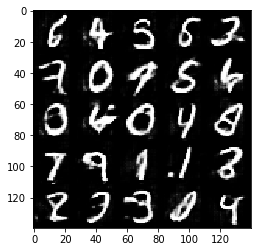

Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 1.3578... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 0.8676
Epoch 2/2... Discriminator Loss: 1.4049... Generator Loss: 0.5527
Epoch 2/2... Discriminator Loss: 1.3254... Generator Loss: 0.7707


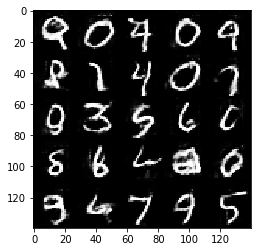

Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.5560
Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.8239
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.8200
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 0.6083
Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.7352


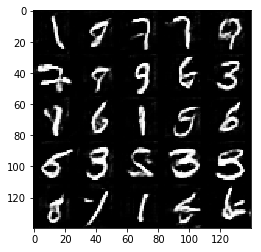

Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.6805
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.7106
Epoch 2/2... Discriminator Loss: 1.4336... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 0.7367


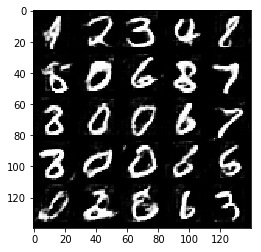

Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.7300
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 1.4077... Generator Loss: 0.6281
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.7261


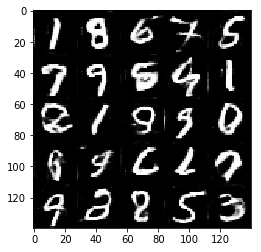

Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.7799
Epoch 2/2... Discriminator Loss: 1.3244... Generator Loss: 0.7917
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.7647


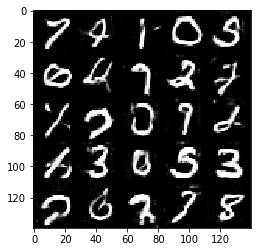

Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.7676
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.7065
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.9395
Epoch 2/2... Discriminator Loss: 1.4066... Generator Loss: 0.7156


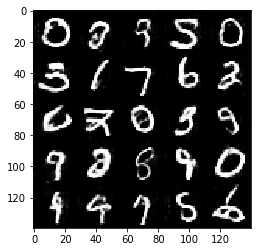

Epoch 2/2... Discriminator Loss: 1.3242... Generator Loss: 0.8443
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 0.7497


In [13]:
batch_size = 32
z_dim = 96
learning_rate = 0.0008
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.5856
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.9428


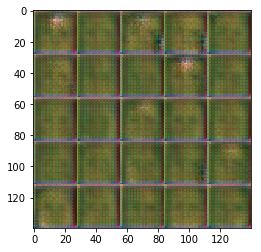

Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6103


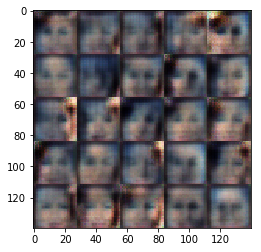

Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7554


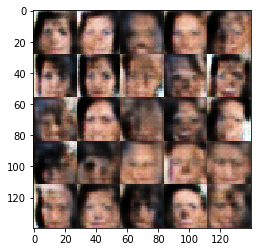

Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7959


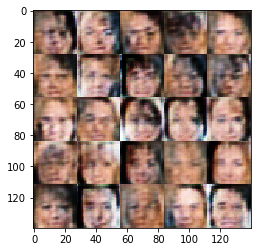

Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7714


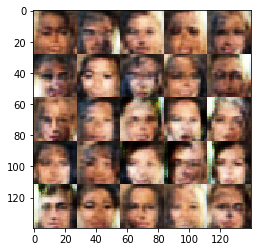

Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8144


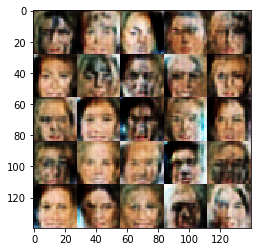

Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7762


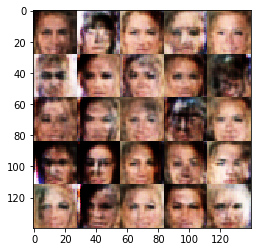

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7798


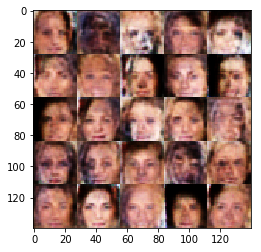

Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8786


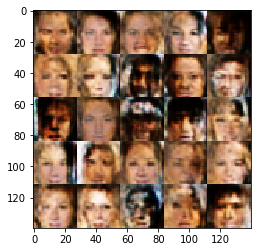

Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7192


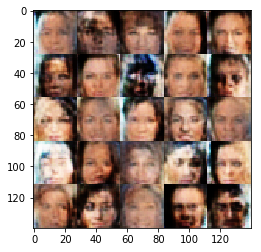

Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7995


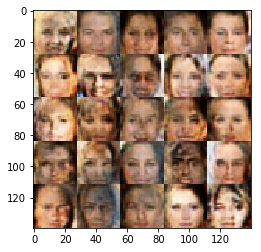

Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7574


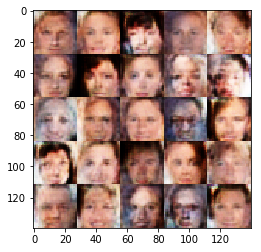

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7700


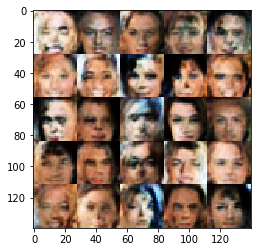

Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7816


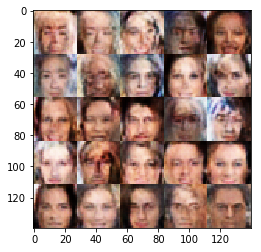

Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7360


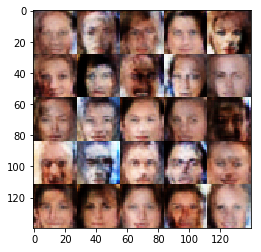

Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8234


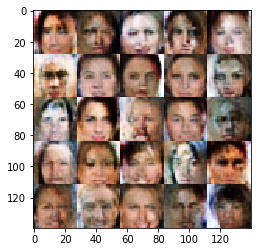

Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7837


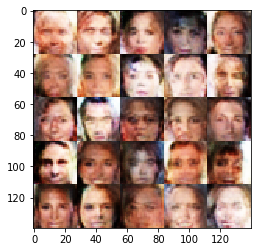

Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7776


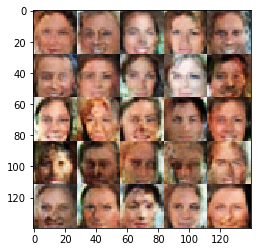

Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7948


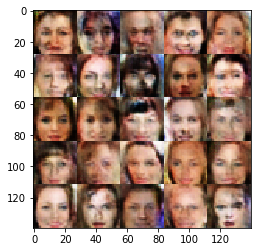

Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7951


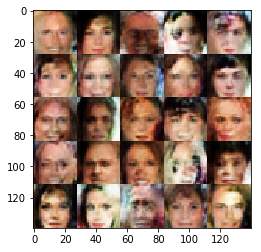

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7906


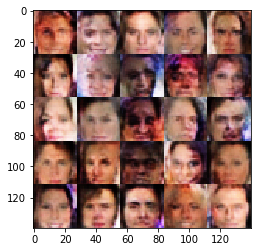

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7577


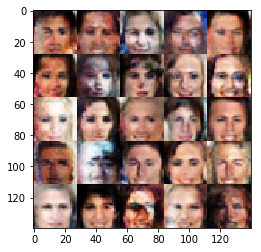

Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7826


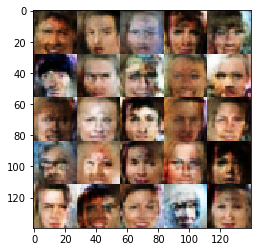

Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8058


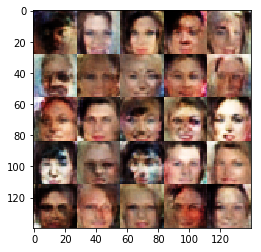

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7772


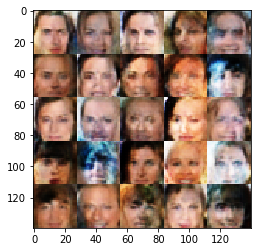

Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8110


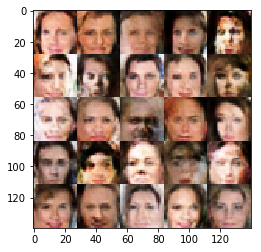

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7370


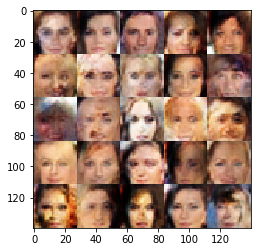

Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7655


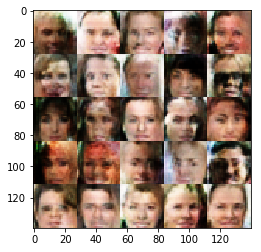

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7406


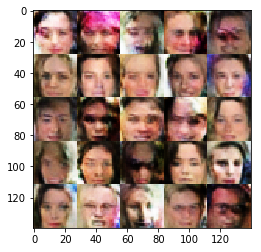

Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7396


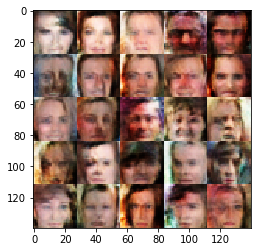

Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7202


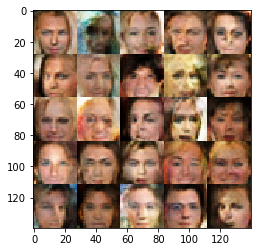

Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7668


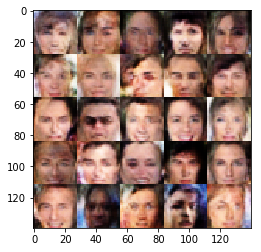

Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7746


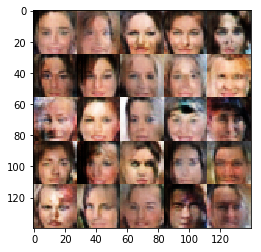

Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7479


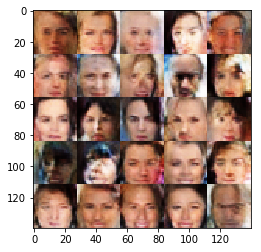

Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8238


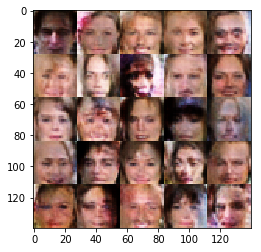

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7950


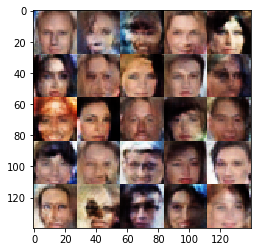

Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7966


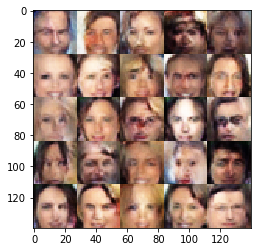

Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7727


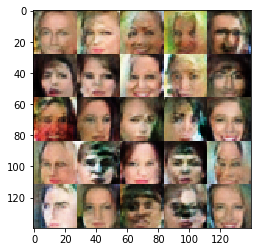

Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7543


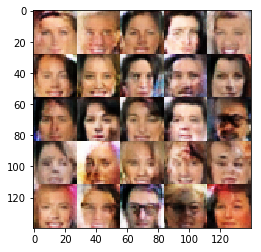

Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7710


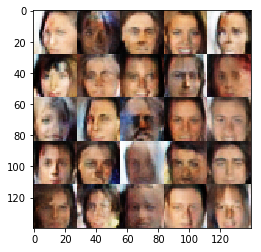

Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7927


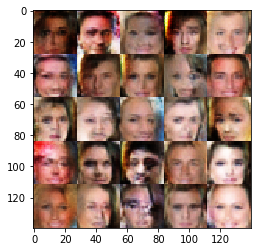

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7852


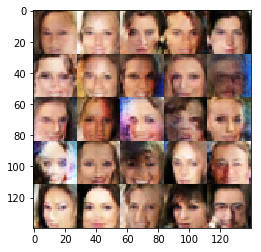

Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7978


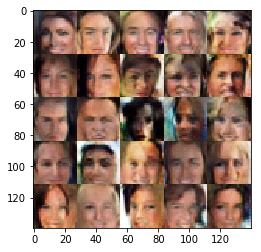

Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8130


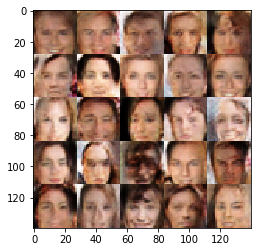

Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.7762


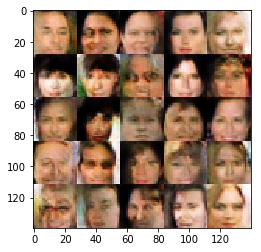

Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7407


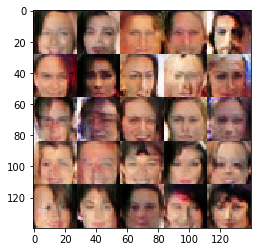

Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7964


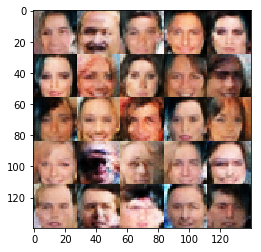

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7713


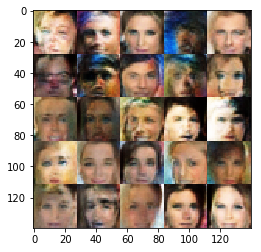

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7620


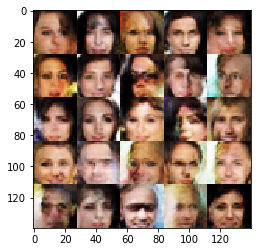

Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7835


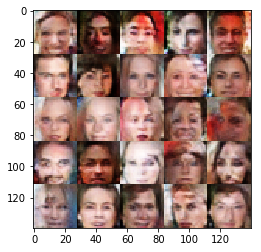

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7589


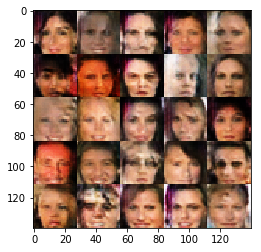

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7331


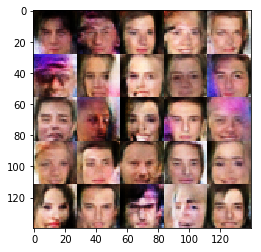

Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7835


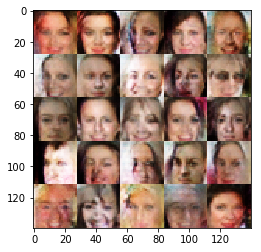

Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.8138


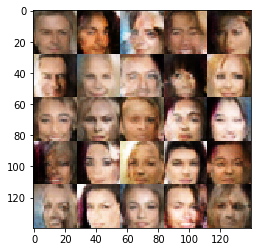

Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8093


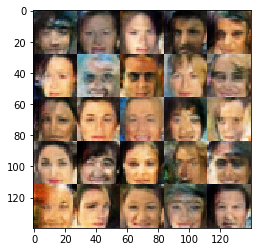

Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8107


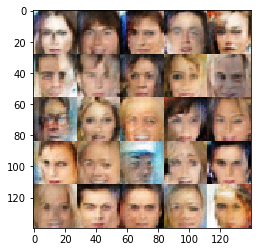

Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7665


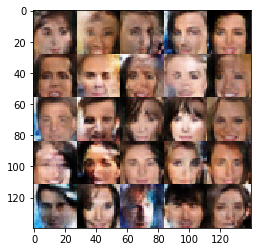

Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7569


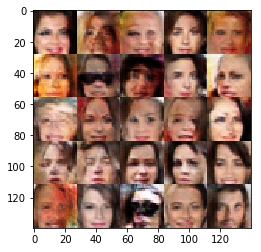

Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7945


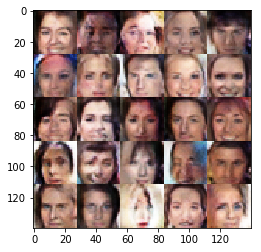

Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7986


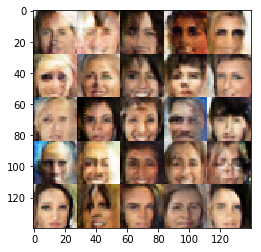

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7635


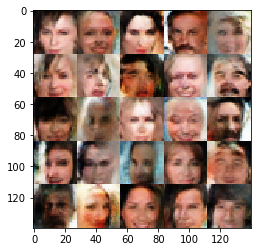

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7734


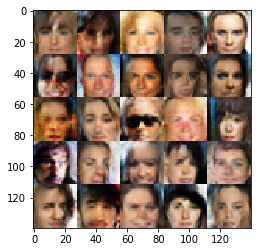

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7293


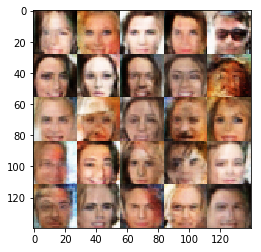

Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7812


In [14]:
batch_size = 32
z_dim = 96
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.